### Importation des bibliothèques 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, truncnorm, uniform
import statsmodels.api as sm

### Données 

In [2]:
X = np.array([1, 1.5, 1.5, 1.5, 2.5, 4, 5, 5, 7, 8, 8.5, 9, 9.5, 9.5, 10,
              12, 12, 13, 13, 14.5, 15.5, 15.5, 16.5, 17, 22.5, 29, 31.5])

Y = np.array([1.8, 1.85, 1.87, 1.77, 2.02, 2.27, 2.15, 2.26, 2.47, 2.19,
              2.26, 2.4, 2.39, 2.41, 2.5, 2.32, 2.32, 2.43, 2.47, 2.56, 2.65,
              2.47, 2.64, 2.56, 2.7, 2.72, 2.57])

In [3]:
donnees = pd.DataFrame({"X": X, "Y": Y})
lissage = sm.nonparametric.lowess
points_lisses = lissage(donnees["Y"], donnees["X"], frac=0.4)

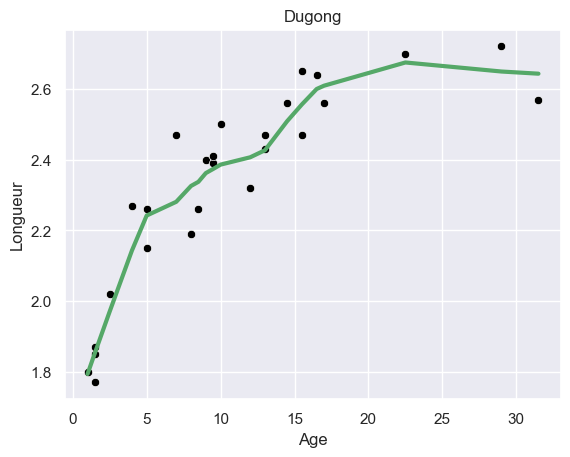

In [11]:
# Visualisation 
sns.set_theme()
sns.scatterplot(x="X", y="Y", data=donnees, color='black')
plt.plot(points_lisses[:, 0], points_lisses[:, 1], 'g-', lw=3)
plt.title("Dugong")
plt.xlabel("Age")
plt.ylabel("Longueur")
plt.show()

## Fonctions Utilitaires pour le code

In [6]:
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

In [7]:
def gibbs_sampling(age, Y, nchain=10**4, prop_sd=np.array([0.01, 0.1, 1, 0.01])):
    init = np.array([2, 1, 11, 0.9])
    chain = np.empty((nchain + 1, 4))
    chain[0, :] = init
    n = len(Y)
    sig = 1000

    for iter in range(nchain):
        current = chain[iter, :]

        # Update alpha
        prop = current.copy()
        prop[0] = np.random.lognormal(np.log(current[0]), prop_sd[0])
        kernel_ratio = prop[0] / current[0]

        top = np.sum(norm.logpdf(Y, prop[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(prop[0], 0, sig)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(current[0], 0, sig)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update beta
        prop = current.copy()
        prop[1] = np.random.lognormal(np.log(current[1]), prop_sd[1])
        kernel_ratio = prop[1] / current[1]

        top = np.sum(norm.logpdf(Y, current[0] - prop[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(prop[1], 0, sig)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(current[1], 0, sig)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update tau
        prop = current.copy()
        prop[2] = np.random.lognormal(np.log(current[2]), prop_sd[2])

        kernel_ratio = prop[2] / current[2]

        top = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(prop[2]))) + \
            gamma.logpdf(prop[2], a=0.001, scale=1/0.001)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            gamma.logpdf(current[2], a=0.001, scale=1/0.001)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()
        # Update gamma
        prop = current.copy()
        prop[3] = np.random.lognormal(np.log(current[3]), prop_sd[3])

        kernel_ratio = prop[3] / current[3]
        top = np.sum(norm.logpdf(Y, current[0] - current[1] * prop[3] ** age, 1 / np.sqrt(current[2]))) + \
            uniform.logpdf(prop[3], 0.5, 0.5)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            uniform.logpdf(current[3], 0.5, 0.5)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob and prop[3] < 1:
            current = prop.copy()

        # Save the new state
        chain[iter + 1, :] = current

    return chain

## Visualization of the parameters $\alpha , \tau, \gamma , \beta $ : 


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

nchain = 10000
chain = gibbs_sampling(X, Y, nchain)

# Remove burning period
burn_in = 1000
chain = chain[burn_in:]

# Set the style for the plots
sns.set(style="whitegrid")

param_names = ['alpha', 'beta', 'tau', 'gamma']

def plot_trace(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        ax.plot(chains[:, idx], alpha=0.7)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

def plot_histograms(chains, param_names):
    n_params = len(param_names)+
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        sns.histplot(chains[:, idx], kde=True, ax=ax)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

plot_trace(chain, param_names)
plot_histograms(chain, param_names)
